In [1]:
from common_func import *
if type_of_script() == 'jupyter': from tqdm.notebook import tqdm
else: from tqdm import tqdm
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D, proj3d
#import cmasher as cmr

import numpy as np
import os, glob, atexit, signal, time, warnings, argparse, subprocess

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle

from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value

In [2]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
nh = uri.RamsesSnapshot(repo, iout, mode=rurmode)
nhs = uri.TimeSeries(nh)
nhs.read_iout_avail()
nout = nhs.iout_avail['iout']
gals = uhmi.HaloMaker.load(nh, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(nh, galaxy=False, double_precision=dp)
database = f"/home/jeon/MissingSat/database"
LG = pklload(f"{database}/LG")
keys = []
for key in LG.keys():
    if(LG[key]['isLG']): keys.append(key)
keys = np.array(keys)
print(keys)

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)
[  1   3   7   8  10  23  25  26  36  64 121 129  11]


In [3]:
allsubs = None
states = None
for key in LG.keys():
    subs = LG[key]['subs']
    assert (subs['Host'] == key).all()
    real = LG[key]['real']
    dink = real[real['state']=='dink']['hid']
    dink_ind = isin(subs['id'], dink)
    subs['dink'][dink_ind] = True
    subs['dink'][~dink_ind] = False

    state = np.zeros(len(subs), dtype='<U7')
    state[dink_ind] = 'dink'
    state[~dink_ind] = 'pair'
    upair = real[real['state']=='upair']['hid']
    u_ind = isin(subs['id'], upair)
    state[u_ind] = 'upair'

    allsubs = subs if allsubs is None else np.hstack((allsubs, subs))
    states = state if states is None else np.hstack((states, state))
    # if(key==): print(subs[state=='dink']['id'])
argsort = np.argsort(allsubs['id'])
allsubs = allsubs[argsort]; states = states[argsort]
LGmask = isin(allsubs['Host'], keys)
# allsubs = allsubs[LGmask]; states = states[LGmask]
len(allsubs)

3851

In [4]:
subs = None; dinks = None; pairs = None; upairs = None
for key in keys:
    tmp = LG[key]['subs']
    subs = tmp if(subs is None) else np.hstack((subs, tmp))

    real = LG[key]['real']

    dink_hids = real[real['state'] == 'dink']['hid']
    tmp1 = tmp[isin(tmp['id'], dink_hids)]
    if(len(tmp1)>0):
        dinks = tmp1 if(dinks is None) else np.hstack((dinks, tmp1))
    pair_hids = real[real['state'] == 'pair']['hid']
    tmp1 = tmp[isin(tmp['id'], pair_hids)]
    if(len(tmp1)>0):
        pairs = tmp1 if(pairs is None) else np.hstack((pairs, tmp1))
    upair_hids = real[real['state'] == 'upair']['hid']
    tmp1 = tmp[isin(tmp['id'], upair_hids)]
    if(len(tmp1)>0):
        upairs = tmp1 if(upairs is None) else np.hstack((upairs, tmp1))
print(len(subs), len(dinks), len(pairs), len(upairs))

1336 1145 130 61


In [55]:
def out2gyr(outs):
    global nhs
    table = nhs.iout_avail
    gyrs = np.zeros(len(outs))
    for i, iout in enumerate(outs):
        gyrs[i] = table[table['iout']==iout][0]['age']
    return gyrs

In [5]:
reduced_tree = pklload(f"{database}/06_reduced_tree.pickle")

In [18]:
maintree = {}
for key in keys:
    maintree[key] = None

for i in range(10):
    tmp = pklload(f"{database}/main_prog/mainhalos_{i}.pickle")
    for key in tmp.keys():
        maintree[key] = tmp[key] if(maintree[key] is None) else np.hstack((maintree[key], tmp[key]))

for key in keys:
    argsort = np.argsort(-maintree[key]['timestep'])
    maintree[key] = maintree[key][argsort]

  0%|          | 0/123 [00:00<?, ?it/s]

(0.0, 2.5)

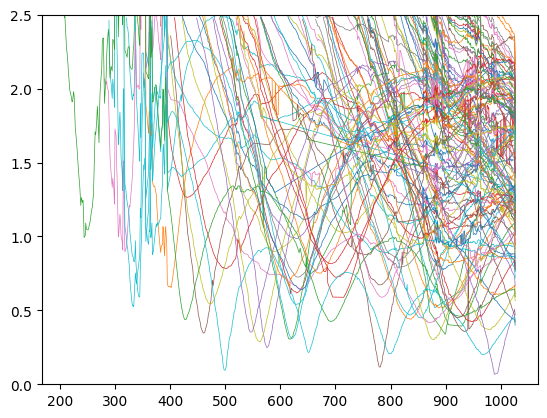

In [53]:
key = 1
idinks = dinks[dinks['Host'] == key]
imain = maintree[key]

infalls_dink = np.zeros(len(idinks))
for i, isub in tqdm(enumerate(idinks), total=len(idinks)):
    itree = reduced_tree[isub['id']]
    itree = itree[itree['take_score']>0.1]
    ind = isin(itree['timestep'], imain['timestep'])
    itree = itree[ind]
    ind = isin(imain['timestep'], itree['timestep'])
    jmain = imain[ind]
    dist = distance(itree, jmain)/jmain['r200_code']
    where = np.where(dist < 2.5)[0][-1]+1
    infalls_dink[i] = jmain[where-1]['timestep']
    
    plt.plot(jmain['timestep'][:where], dist[:where], lw=0.5)
plt.ylim(0,2.5)

  0%|          | 0/12 [00:00<?, ?it/s]

(0.0, 2.5)

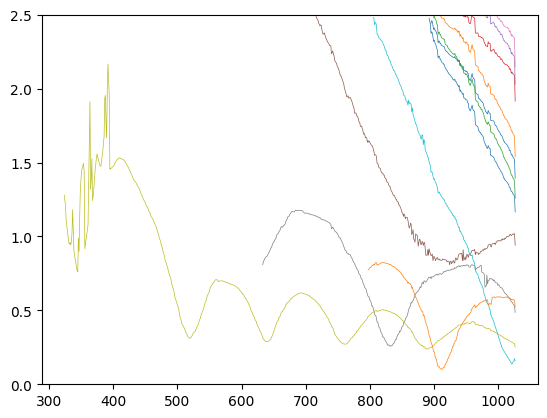

In [54]:
key = 1
ipairs = pairs[pairs['Host'] == key]
imain = maintree[key]

infalls_pair = np.zeros(len(ipairs))
for i, isub in tqdm(enumerate(ipairs), total=len(ipairs)):
    itree = reduced_tree[isub['id']]
    itree = itree[itree['take_score']>0.1]
    ind = isin(itree['timestep'], imain['timestep'])
    itree = itree[ind]
    ind = isin(imain['timestep'], itree['timestep'])
    jmain = imain[ind]
    dist = distance(itree, jmain)/jmain['r200_code']
    where = np.where(dist < 2.5)[0][-1]+1
    infalls_pair[i] = jmain[where-1]['timestep']
    
    plt.plot(jmain['timestep'][:where], dist[:where], lw=0.5)
plt.ylim(0,2.5)

In [62]:
nhs.iout_avail['age'].max()

11.62402615

(array([0.46340762, 0.34755571, 0.23170381, 0.1158519 , 0.        ,
        0.1158519 , 0.        , 0.        , 0.        , 0.1158519 ]),
 array([0.22558742, 0.94489655, 1.66420569, 2.38351482, 3.10282396,
        3.82213309, 4.54144223, 5.26075136, 5.98006049, 6.69936963,
        7.41867876]),
 <BarContainer object of 10 artists>)

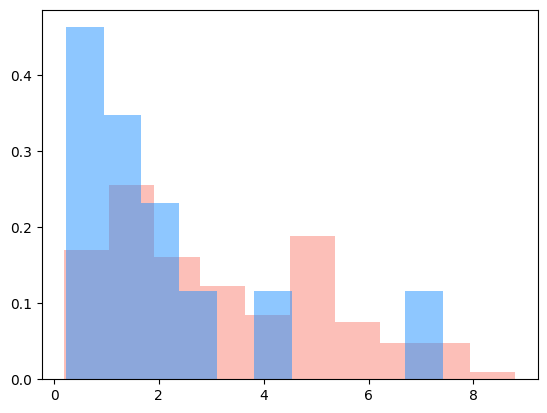

In [63]:
plt.hist(nhs.iout_avail['age'].max()-out2gyr(infalls_dink), color='salmon', density=True, alpha=0.5)
plt.hist(nhs.iout_avail['age'].max()-out2gyr(infalls_pair), color='dodgerblue', density=True, alpha=0.5)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

130 1145
[0.         0.         0.         1.02882096 0.         0.
 0.10480349 0.06812227 0.12925764 0.12925764 0.08558952 0.05065502
 0.04716157 0.04541485 0.06812227 0.05065502 0.0489083  0.0279476
 0.03144105 0.02969432 0.01921397 0.0139738  0.01048035 0.00873362
 0.00174672 0.         0.         0.         0.        ]
[0.         0.         0.         0.64615385 0.         0.
 0.15384615 0.23076923 0.09230769 0.09230769 0.12307692 0.03076923
 0.07692308 0.07692308 0.09230769 0.03076923 0.12307692 0.06153846
 0.03076923 0.01538462 0.07692308 0.04615385 0.         0.
 0.         0.         0.         0.         0.        ]


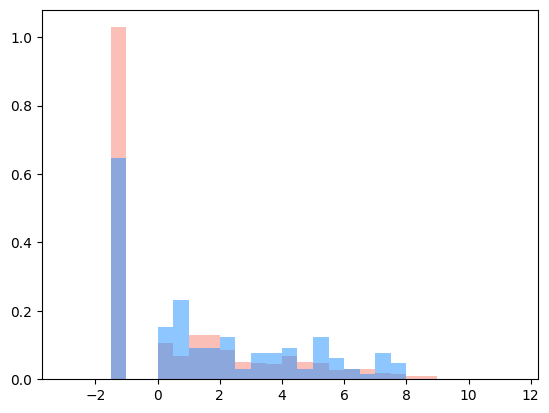

In [101]:
infalls_dink = np.zeros(len(dinks))
cursor = 0
for key in tqdm(keys):
    idinks = dinks[dinks['Host'] == key]
    imain = maintree[key]
    for i, isub in enumerate(idinks):
        itree = reduced_tree[isub['id']]
        itree = itree[itree['take_score']>0.1]
        ind = isin(itree['timestep'], imain['timestep'])
        itree = itree[ind]
        ind = isin(imain['timestep'], itree['timestep'])
        jmain = imain[ind]
        assert len(jmain)>0
        dist = distance(itree, jmain)/jmain['r200_code']
        if True in (dist < 1):
            where = np.where(dist < 1)[0][-1]+1
            infalls_dink[cursor+i] = jmain[where-1]['timestep']
        else:
            infalls_dink[cursor+i] = -1
        
        # plt.plot(jmain['timestep'][:where], dist[:where], lw=0.5)
    cursor += len(idinks)
infalls_dink = infalls_dink[infalls_dink != 0]

infalls_pair = np.zeros(len(pairs))
cursor = 0
for key in tqdm(keys):
    ipairs = pairs[pairs['Host'] == key]
    imain = maintree[key]
    for i, isub in enumerate(ipairs):
        itree = reduced_tree[isub['id']]
        itree = itree[itree['take_score']>0.1]
        ind = isin(itree['timestep'], imain['timestep'])
        itree = itree[ind]
        ind = isin(imain['timestep'], itree['timestep'])
        jmain = imain[ind]
        assert len(jmain)>0
        dist = distance(itree, jmain)/jmain['r200_code']
        if True in (dist < 1):
            where = np.where(dist < 1)[0][-1]+1
            infalls_pair[cursor+i] = jmain[where-1]['timestep']
        else:
            infalls_pair[cursor+i] = -1
        
        # plt.plot(jmain['timestep'][:where], dist[:where], lw=0.5)
    cursor += len(ipairs)
infalls_pair = infalls_pair[infalls_pair != 0]

print(len(infalls_pair),len(infalls_dink))

mask = infalls_dink>0
lookbacks = np.zeros(len(infalls_dink))
lookbacks[mask] = nhs.iout_avail['age'].max()-out2gyr(infalls_dink[mask])
lookbacks[~mask] = -1.25
h=plt.hist(lookbacks, color='salmon', density=True, alpha=0.5, bins = np.arange(-3,12,0.5))
print(h[0])
mask = infalls_pair>0
lookbacks = np.zeros(len(infalls_pair))
lookbacks[mask] = nhs.iout_avail['age'].max()-out2gyr(infalls_pair[mask])
lookbacks[~mask] = -1.25
h=plt.hist(lookbacks, color='dodgerblue', density=True, alpha=0.5, bins = np.arange(-3,12,0.5))
print(h[0])

In [88]:
len(infalls_pair),len(infalls_dink)

(130, 1145)

[0.         0.         0.         1.02882096 0.         0.
 0.10480349 0.06812227 0.12925764 0.12925764 0.08558952 0.05065502
 0.04716157 0.04541485 0.06812227 0.05065502 0.0489083  0.0279476
 0.03144105 0.02969432 0.01921397 0.0139738  0.01048035 0.00873362
 0.00174672 0.         0.         0.         0.        ]
[0.         0.         0.         0.64615385 0.         0.
 0.15384615 0.23076923 0.09230769 0.09230769 0.12307692 0.03076923
 0.07692308 0.07692308 0.09230769 0.03076923 0.12307692 0.06153846
 0.03076923 0.01538462 0.07692308 0.04615385 0.         0.
 0.         0.         0.         0.         0.        ]


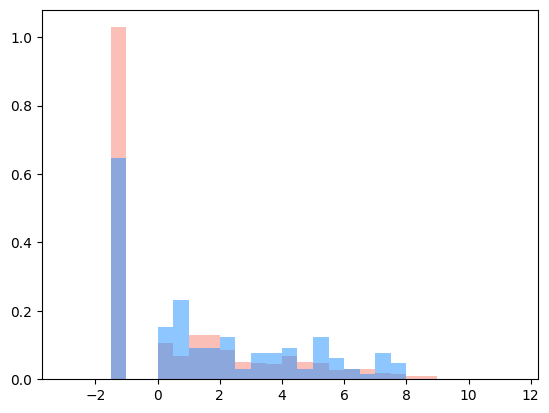

In [96]:
mask = infalls_dink>0
lookbacks = np.zeros(len(infalls_dink))
lookbacks[mask] = nhs.iout_avail['age'].max()-out2gyr(infalls_dink[mask])
lookbacks[~mask] = -1.25
h=plt.hist(lookbacks, color='salmon', density=True, alpha=0.5, bins = np.arange(-3,12,0.5))
print(h[0])
mask = infalls_pair>0
lookbacks = np.zeros(len(infalls_pair))
lookbacks[mask] = nhs.iout_avail['age'].max()-out2gyr(infalls_pair[mask])
lookbacks[~mask] = -1.25
h=plt.hist(lookbacks, color='dodgerblue', density=True, alpha=0.5, bins = np.arange(-3,12,0.5))
print(h[0])

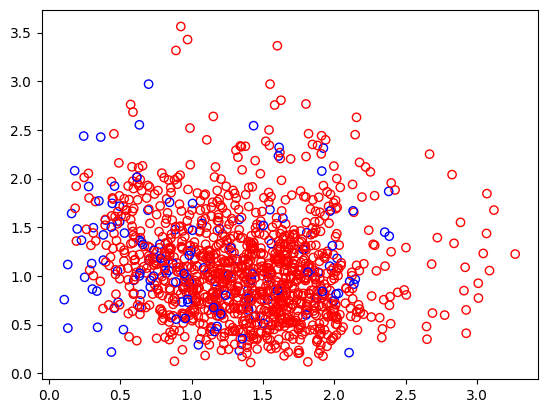

In [100]:
for key in keys:
    BGG = LG[key]['BGG']
    idinks = dinks[dinks['Host']==key]
    ddist = distance(BGG, idinks)/BGG['r200_code']
    dvels = distance(BGG, idinks, vel=True)/BGG['sigma']
    plt.scatter(ddist, dvels, ec='r', fc='none')

    ipairs = pairs[pairs['Host']==key]
    pdist = distance(BGG, ipairs)/BGG['r200_code']
    pvels = distance(BGG, ipairs, vel=True)/BGG['sigma']
    plt.scatter(pdist, pvels, ec='b', fc='none')

# Infall Property

In [103]:
itree.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('mcontam', '<f8'), ('r10_mem', '<f8'), ('r50_mem', '<f8'), ('r90_mem', '<f8'), ('r10_vir', '<f8'), ('r50_vir', '<f8'), ('r90_vir', '<f8'), ('r10_max', '<f8'), ('r50_max', '<f8'), ('r90_max', '<f8'), ('sub', '<i8'), ('dink', '?'), ('mdm', '<f8'), ('mstar', '<f8'), ('mcold', '<f8'), ('mcell', '<f8'), ('Host', '<i4'), ('r200kpc', '<f8'), ('m200', '<f8'), ('r200', '<f8'), ('mdm_vir', '<f8'), ('mstar_vir', '<f8'), ('mcell_vir', '<f8'), ('mcold_vi

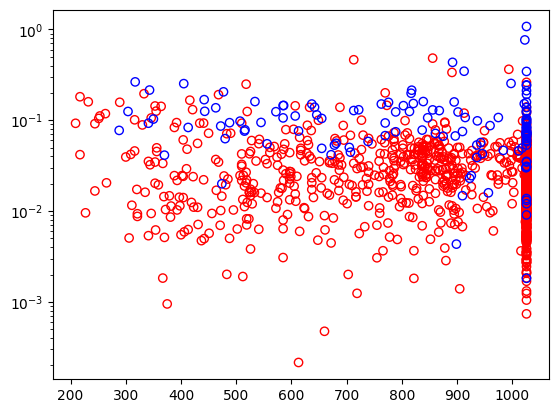

In [153]:
plt.scatter(infalls_dink['timestep'], infalls_dink['mcell_vir']/infalls_dink['mdm_vir'], fc='none', ec='r')
plt.scatter(infalls_pair['timestep'], infalls_pair['mcell_vir']/infalls_pair['mdm_vir'], fc='none', ec='b')
plt.yscale('log')

In [196]:
minmax( reduced_tree[isub['id']]['take_score'] )

len842: min=0.12368715259735147, mean=0.39369154321057354, max=1.0


In [351]:
dcut = 1.5

gdinks = dinks[(dinks['mvir']>=10**8.3)&(dinks['mvir']<=10**9.3)]
at_dink = np.zeros(len(gdinks), dtype=itree.dtype)
ddists = np.zeros(len(gdinks))
dmaxs =  np.zeros((2,len(gdinks)))
    
for i, isub in tqdm( enumerate(gdinks), total=len(gdinks) ):
    itree = reduced_tree[isub['id']]
    imain = maintree[isub['Host']]
    ind = isin(itree['timestep'], imain['timestep'])
    itree = itree[ind]
    ind = isin(imain['timestep'], itree['timestep'])
    jmain = imain[ind]
    assert len(jmain)>0
    dist = distance(itree, jmain)/jmain['r200_code']
    dmaxs[0][i] = itree[np.argmax(dist)]['timestep']
    dmaxs[1][i] = np.max(dist)
    if True in (dist < dcut):
        where = np.where(dist < dcut)[0][-1]+1
    else:
        where = 1
    at_dink[i] = itree[where-1]#jmain[where-1]['timestep']
    ddists[i] = distance(itree[where-1], jmain[where-1])/jmain[where-1]['r200_code']

gpairs = pairs[(pairs['mvir']>=10**8.3)&(pairs['mvir']<=10**9.3)]
at_pair = np.zeros(len(gpairs), dtype=itree.dtype)
pdists = np.zeros(len(gpairs))
pmaxs =  np.zeros((2,len(gpairs)))
for i, isub in tqdm( enumerate(gpairs), total=len(gpairs) ):
    itree = reduced_tree[isub['id']]
    imain = maintree[isub['Host']]
    ind = isin(itree['timestep'], imain['timestep'])
    itree = itree[ind]
    ind = isin(imain['timestep'], itree['timestep'])
    jmain = imain[ind]
    assert len(jmain)>0
    dist = distance(itree, jmain)/jmain['r200_code']
    pmaxs[0][i] = itree[np.argmax(dist)]['timestep']
    pmaxs[1][i] = np.max(dist)
    if True in (dist < dcut):
        where = np.where(dist < dcut)[0][-1]+1
    else:
        where = 1
    at_pair[i] = itree[where-1]#jmain[where-1]['timestep']
    pdists[i] = distance(itree[where-1], jmain[where-1])/jmain[where-1]['r200_code']

  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

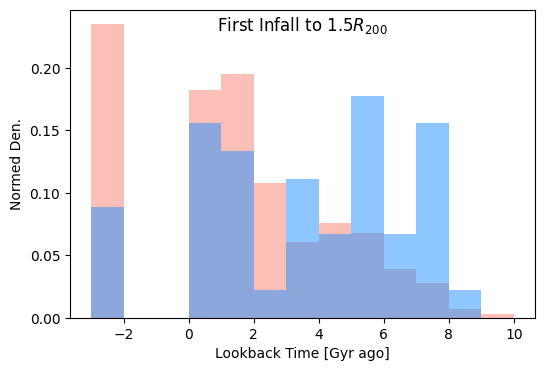

In [338]:
fig, ax = plt.subplots(figsize=(6,4))
dmask = (ddists<dcut)
gyrs = out2gyr(at_dink['timestep'])[dmask]
lookbacks = nhs.iout_avail['age'].max()-gyrs
lookbacks = np.hstack(( lookbacks, np.full(np.sum(~dmask),-2.5) ))
h=ax.hist(lookbacks, color='salmon', density=True, alpha=0.5, bins = np.arange(-3,11,1), label='Starless')
pmask = (pdists<dcut)
gyrs = out2gyr(at_pair['timestep'])[pmask]
lookbacks = nhs.iout_avail['age'].max()-gyrs
lookbacks = np.hstack(( lookbacks, np.full(np.sum(~pmask),-2.5) ))
h=ax.hist(lookbacks, color='dodgerblue', density=True, alpha=0.5, bins = np.arange(-3,11,1), label='Pair')

ax.text(0.5, 0.95, "First Infall to 1.5$R_{200}$", ha='center', va='center', transform=ax.transAxes, fontsize=12)
ax.set_ylabel("Normed Den.")
ax.set_xlabel("Lookback Time [Gyr ago]")

plt.savefig("06_wheninfall.png", dpi=400, transparent=False, facecolor='w', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

Text(0, 0.5, 'Cold Gas Fraction')

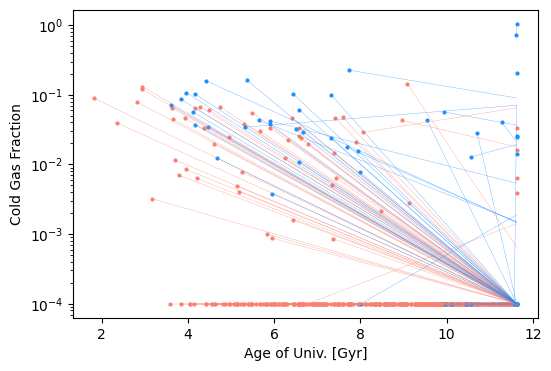

In [345]:
fig, ax = plt.subplots(figsize=(6,4))
plt.subplots_adjust(wspace=0)


for i in range(len(gdinks)):
    a = at_dink[i]; b = gdinks[i]
    if(a['timestep']==1026):continue
    aval = a['mcold_vir']/a['mdm_vir']
    if(aval<1e-4): aval=1e-4
    bval = b['mcold_vir']/b['mdm_vir']
    if(bval<1e-4): bval=1e-4
    plt.plot(
             out2gyr([a['timestep'],b['timestep']]),
             [aval, bval],
             color='salmon', lw=0.2
             )
vals = at_dink['mcold_vir']/at_dink['mdm_vir']
vals[vals<1e-4] = 1e-4
ax.scatter( out2gyr(at_dink['timestep']), vals, color='salmon', s=4)


for i in range(len(gpairs)):
    a = at_pair[i]; b = gpairs[i]
    if(a['timestep']==1026):continue
    aval = a['mcold_vir']/a['mdm_vir']
    if(aval<1e-4): aval=1e-4
    bval = b['mcold_vir']/b['mdm_vir']
    if(bval<1e-4): bval=1e-4
    plt.plot(
             out2gyr([a['timestep'],b['timestep']]),
             [aval, bval],
             color='dodgerblue', lw=0.2
             )
vals = at_pair['mcold_vir']/at_pair['mdm_vir']
vals[vals==0] = 1e-4
ax.scatter( out2gyr(at_pair['timestep']), vals, color='dodgerblue', s=4)


ax.set_yscale('log')
ax.set_xlabel("Age of Univ. [Gyr]")
ax.set_ylabel("Cold Gas Fraction")

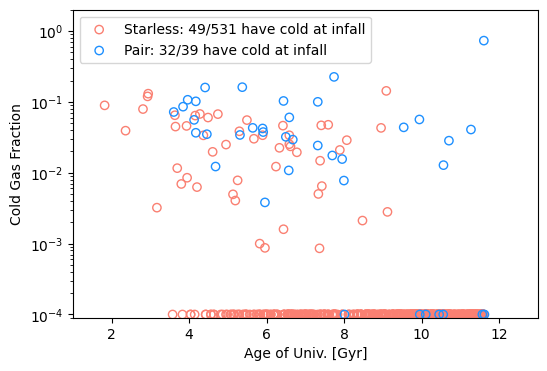

In [360]:
fig, ax = plt.subplots(figsize=(6,4))
plt.subplots_adjust(wspace=0)

mask = at_dink['timestep']<1026
vals = (at_dink['mcold_vir']/at_dink['mdm_vir'])[mask]
vmask = vals <= 1e-4
vals[vmask] = 1e-4
ax.scatter(out2gyr(at_dink['timestep'][mask]), vals, fc='none', ec='salmon', label=f"Starless: {np.sum(~vmask)}/{len(vmask)} have cold at infall")
bins = np.logspace(np.nanmin(np.log10(vals[vals>0])),np.max(np.log10(vals)), 20)

mask = at_pair['timestep']<1026
vals = (at_pair['mcold_vir']/at_pair['mdm_vir'])[mask]
vmask = vals <= 1e-4
vals[vmask] = 1e-4
ax.scatter(out2gyr(at_pair['timestep'][mask]), vals, fc='none', ec='dodgerblue', label=f"Pair: {np.sum(~vmask)}/{len(vmask)} have cold at infall")
bins = np.logspace(np.nanmin(np.log10(vals[vals>0])),np.max(np.log10(vals)), 20)
ax.set_yscale('log')

ax.set_xlim(1, 13)
ax.set_ylim(9e-5,2e0)

ax.legend(frameon=True)
ax.set_xlabel("Age of Univ. [Gyr]")
ax.set_ylabel("Cold Gas Fraction")

plt.savefig("06_coldfrac.png", dpi=400, transparent=False, facecolor='w', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

Text(0, 0.5, 'Cold Gas Fraction')

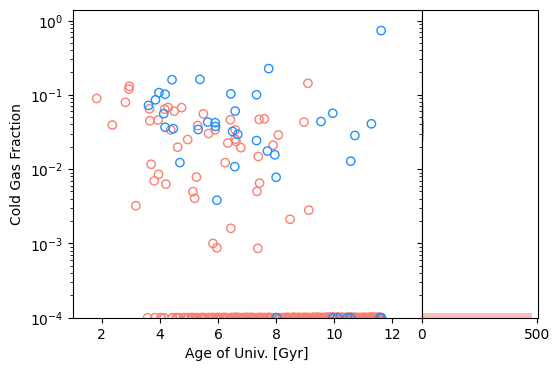

In [346]:
fig, axes = plt.subplots(ncols=2, figsize=(6,4), sharey=True, gridspec_kw={'width_ratios':[3,1]})
plt.subplots_adjust(wspace=0)

ax = axes[0]
ax1 = axes[1]
mask = at_dink['timestep']<1026
vals = (at_dink['mcold_vir']/at_dink['mdm_vir'])[mask]
vals[vals==0] = 1e-4
ax.scatter(out2gyr(at_dink['timestep'][mask]), vals, fc='none', ec='salmon', )
bins = np.logspace(np.nanmin(np.log10(vals[vals>0])),np.max(np.log10(vals)), 20)
ax1.hist(vals, bins=bins, color='salmon', alpha=0.5, orientation='horizontal', density=False)

mask = at_pair['timestep']<1026
vals = (at_pair['mcold_vir']/at_pair['mdm_vir'])[mask]
vals[vals==0] = 1e-4
ax.scatter(out2gyr(at_pair['timestep'][mask]), vals, fc='none', ec='dodgerblue')
bins = np.logspace(np.nanmin(np.log10(vals[vals>0])),np.max(np.log10(vals)), 20)
ax1.hist(vals, bins=bins, color='dodgerblue', alpha=0.5, orientation='horizontal', density=False)
ax.set_yscale('log')

ax.set_xlim(1, 13)
ax.set_ylim(1e-4,)

ax.set_xlabel("Age of Univ. [Gyr]")
ax.set_ylabel("Cold Gas Fraction")

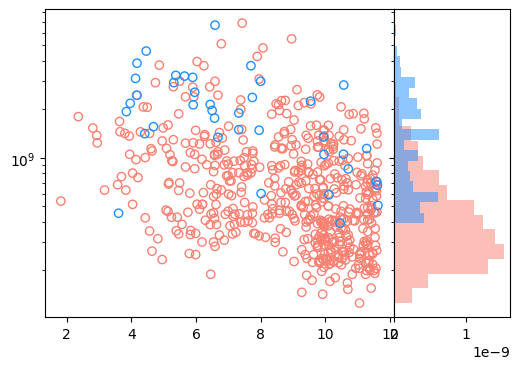

In [333]:
fig, axes = plt.subplots(ncols=2, figsize=(6,4), sharey=True, gridspec_kw={'width_ratios':[3,1]})
plt.subplots_adjust(wspace=0)

ax = axes[0]
ax1 = axes[1]
mask = at_dink['timestep']<1026
vals = (at_dink['mvir'])[mask]
vals[vals==0] = 1e-4
ax.scatter(out2gyr(at_dink['timestep'][mask]), vals, fc='none', ec='salmon')
bins = np.logspace(np.nanmin(np.log10(vals[vals>0])),np.max(np.log10(vals)), 20)
ax1.hist(vals, bins=bins, color='salmon', alpha=0.5, orientation='horizontal', density=True)

mask = at_pair['timestep']<1026
vals = (at_pair['mvir'])[mask]
vals[vals==0] = 1e-4
ax.scatter(out2gyr(at_pair['timestep'][mask]), vals, fc='none', ec='dodgerblue')
bins = np.logspace(np.nanmin(np.log10(vals[vals>0])),np.max(np.log10(vals)), 20)
ax1.hist(vals, bins=bins, color='dodgerblue', alpha=0.5, orientation='horizontal', density=True)
ax.set_yscale('log')

# ax.set_ylim(1e-4,)

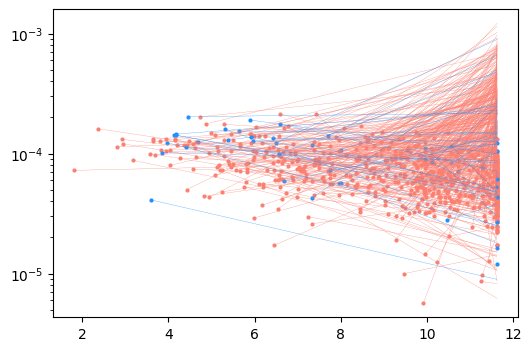

In [335]:
fig, ax = plt.subplots(figsize=(6,4))
plt.subplots_adjust(wspace=0)


for i in range(len(gdinks)):
    a = at_dink[i]; b = gdinks[i]
    if(a['timestep']==1026):continue
    aval = a['r50_vir']
    if(aval==0): aval=1e-6
    bval = b['r50_vir']
    if(bval==0): bval=1e-6
    plt.plot(
             out2gyr([a['timestep'],b['timestep']]),
             [aval, bval],
             color='salmon', lw=0.2
             )
vals = at_dink['r50_vir']
vals[vals==0] = 1e-4
ax.scatter( out2gyr(at_dink['timestep']), vals, color='salmon', s=4)


for i in range(len(gpairs)):
    a = at_pair[i]; b = gpairs[i]
    if(a['timestep']==1026):continue
    aval = a['r50_vir']
    if(aval==0): aval=1e-6
    bval = b['r50_vir']
    if(bval==0): bval=1e-6
    plt.plot(
             out2gyr([a['timestep'],b['timestep']]),
             [aval, bval],
             color='dodgerblue', lw=0.2
             )
vals = at_pair['r50_vir']
vals[vals==0] = 1e-4
ax.scatter( out2gyr(at_pair['timestep']), vals, color='dodgerblue', s=4)


ax.set_yscale('log')

  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

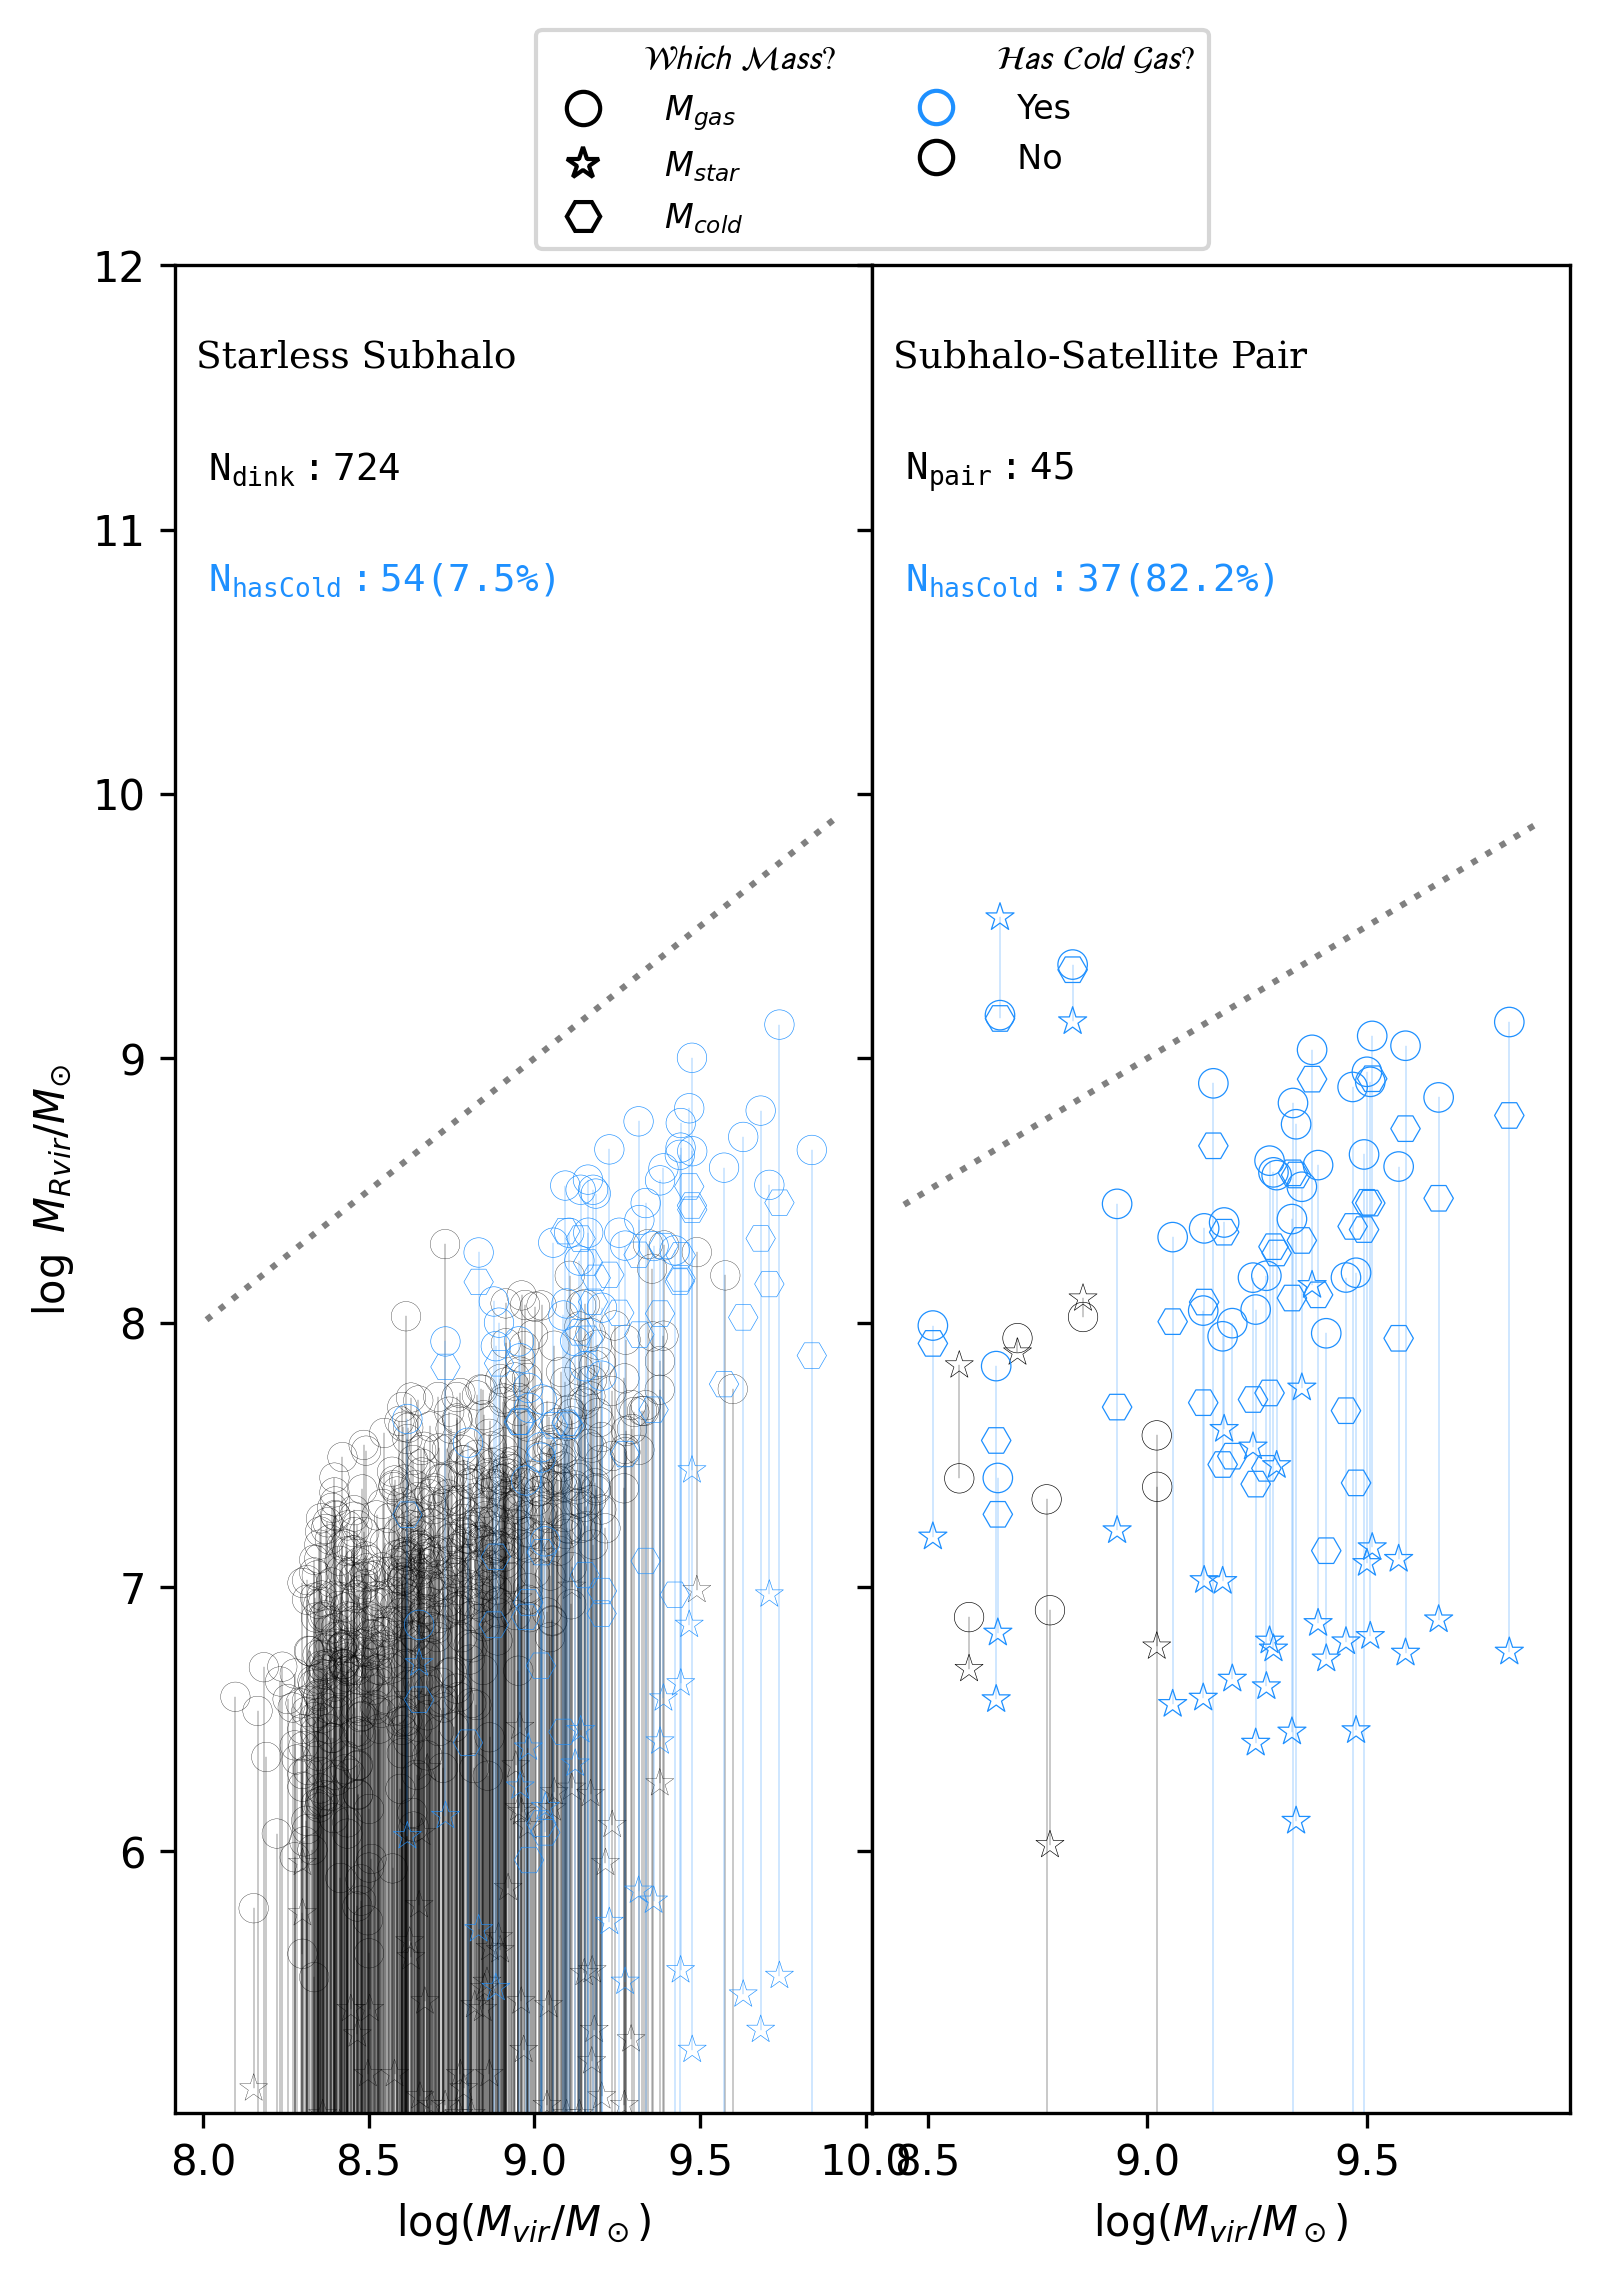

In [347]:
rname='Rvir'; mass_name='mvir'; xlabel='log($M_{vir}/M_\odot$)'
mass_suffix = "" if(mass_name=='mdm') else "_vir"
jump = False
if(not os.path.exists(f"03_components.png"))or(not jump):
    fig, axes = plt.subplots(ncols=2, dpi=300, figsize=(6,8), sharey=True)

    samples = [at_dink, at_pair]
    names = ["dink", "pair"]
    titles = ["Starless Subhalo", "Subhalo-Satellite Pair"]
    for i in range(2):
        ax = axes[i]
        sample = samples[i]
        # sample = sample[(sample['mvir']>=m1)&(sample['mvir']<=m2)]
        mask = sample[f'mcold{mass_suffix}'] < 1e3; sample[f'mcold{mass_suffix}'][mask] = 1e3
        mask = sample[f'mstar{mass_suffix}'] < 1e3; sample[f'mstar{mass_suffix}'][mask] = 1e3
        hascolds = sample[f'mcold{mass_suffix}']>1e3
        for iarr in tqdm(sample):
            hascold = iarr[f'mcold{mass_suffix}']>1e3
            color = 'k' if(not hascold) else 'dodgerblue'
            lw = 0.15 if(not hascold) else 0.3
            zorder = 0 if(not hascold) else 1
            facecolor='none'# if(isdink) else color
            edgecolor=color# if(isdink) else 'none' 
            linecolor=color
            if(i==0): lw/=2
            

            ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mstar{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, marker='*', zorder=zorder)
            if(iarr[f'mcold{mass_suffix}']>1e3): ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcold{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, marker='H', zorder=zorder)
            ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcell{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, zorder=zorder)
            vmax = np.max([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])])
            if(iarr[f'mcold{mass_suffix}']>1e3): 
                vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])]), 3 )
            else:
                vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}'])]), 3 )
            ax.plot([np.log10(iarr[mass_name]),np.log10(iarr[mass_name])], [vmin, vmax], color=linecolor, lw=0.1, zorder=zorder)

        ax.text(0.03, 0.96, f"{titles[i]}", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes, family='serif')
        ax.text(0.03, 0.90, fr"$\mathtt{{ \ N_{{{names[i]}}}: {len(sample)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
        ax.text(0.03, 0.84, fr"$\mathtt{{ \ N_{{hasCold}}: {np.sum(hascolds)}({np.sum(hascolds)/len(sample)*100:.1f}\%) }}$", ha='left', va='top', color='dodgerblue', fontsize=9, transform=ax.transAxes)

    icol = 0
    for ax in axes.flatten():
        # ax.fill_between([7.9,12.1],3, np.log10(np.min(gals1['m'])), ec='none', fc='grey', alpha=0.2, zorder=-1)

        # ax.set_xlim(np.log10(m1/2),np.log10(m2*2))
        xlim = ax.get_xlim()
        ax.plot(xlim, xlim, ls=':', color='grey', zorder=-1)
        ax.set_ylim(5.01,12)
        if(icol==0): ax.set_ylabel(fr"$\log\ M_{{{rname}}}/M_{{\odot}}$")
        ax.set_xlabel(xlabel)
        icol += 1


    # Making Legend
    from matplotlib.lines import Line2D
    # axes[0].set_aspect(np.log10(m2*4/m1)/4/2)
    # axes[1].set_aspect(np.log10(m2*4/m1)/4/2)
    legend_elements = [
        Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Which\ Mass?}$'),
        Line2D([0],[0], marker='o',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{gas}$'),
        Line2D([0],[0], marker='*',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{star}$'),
        Line2D([0],[0], marker='H',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{cold}$'),
        Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Has\ Cold\ Gas?}$'),
        Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='dodgerblue', markersize=8, label='  Yes'),
        Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='k', markersize=8, label='  No'),
    ]

    plt.subplots_adjust(hspace=0, wspace=0)
    axes[1].legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0, 1), fontsize=8, ncols=2)

    plt.savefig(f"06_components_comp.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
    plt.show(); plt.close()